# **Projet de M1 : Étude et implémentation de l'édition d'images par équation de Poisson**

Ce notebook présente une étude comparative de deux méthodes numériques pour la résolution du problème de l'édition d'images par équation de Poisson, une technique performante pour la fusion avec un rendu photoréaliste d'images (*seamless cloning*).

Le projet est structuré en trois parties :

1. **Introduction et théorie** : Présentation du problème du clonage d'images et des fondements mathématiques de la méthode de Poisson, en s'appuyant sur l'article de référence *"Poisson Image Editing"* (Di Martino et al., 2016).

2. **Implémentation des méthodes numériques** :

   - **Méthode 1** : L'approche par différences finies avec un solveur itératif de Jacobi.

   - **Méthode 2** : L'approche directe par transformée de Fourier.

3. **Comparaison et analyse** : Analyse quantitative/qualitative des résultats, des avantages et inconvénients de chaque méthode.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift, fftfreq
import cv2
import time

## 1. Introduction et fondements théoriques

### 1.1 Le problème du clonage naïf

Le principe de la méthode d'édition par équation de Poisson consiste à importer une région d'une image source dans une image cible de manière naturelle, sans créer de discontinuités visibles.

Par exemple, considérons l'objectif suivant : nous souhaitons extraire l'avion de l'image suivante (image source) et l'intégrer dans un paysage (image cible).

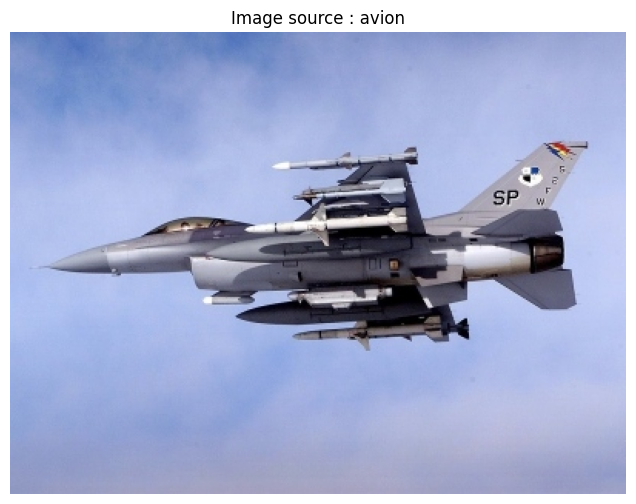

In [2]:
img_source = cv2.imread('avion.jpg')
img_source_rgb = cv2.cvtColor(img_source, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(img_source_rgb)
plt.title("Image source : avion")
plt.axis('off')
plt.show()

Et l'intégrer dans ce paysage (image cible) :

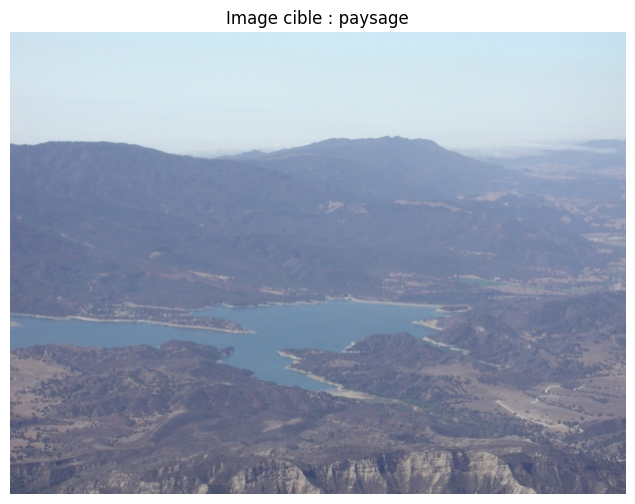

In [3]:
img_cible = cv2.imread('paysage.jpg')
img_cible_rgb = cv2.cvtColor(img_cible, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(img_cible_rgb)
plt.title("Image cible : paysage")
plt.axis('off')
plt.show()

Nous disposons également d'un masque binaire qui délimite précisément la région de l'avion à extraire :

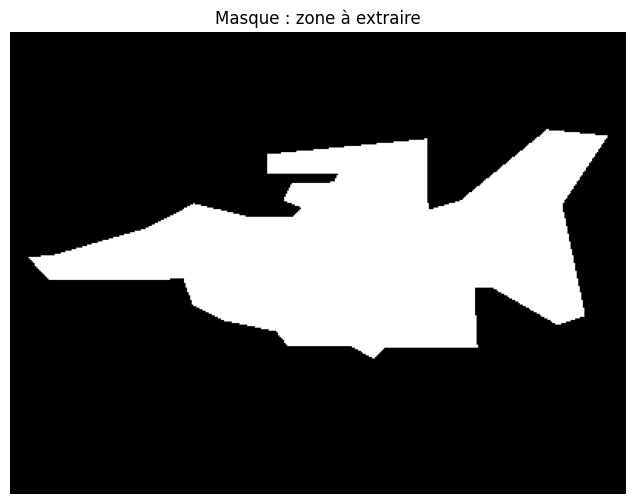

In [4]:
mask = cv2.imread('mask_avion.png', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(8, 6))
plt.imshow(mask, cmap='gray')
plt.title("Masque : zone à extraire")
plt.axis('off')
plt.show()

#### Approche naïve : copier-coller direct

La méthode la plus simple consiste à copier directement les pixels de l'image source dans l'image cible, en utilisant le masque pour délimiter la région. Implémentons cette approche :

In [5]:
def copier_coller_naif(source, target, mask, x0, y0):
    """
    Réalise un copier-coller naïf de la région source dans la cible.

    Args:
        source (np.ndarray): Image source (H x W x 3).
        target (np.ndarray): Image cible (H' x W' x 3).
        mask (np.ndarray): Masque binaire (H x W) délimitant la région à copier.
        x0, y0 (int): Coordonnées du coin supérieur gauche de la zone de collage dans l'image cible.

    Returns:
        np.ndarray: Image cible avec la région source collée.
    """
    resultat = target.copy()
    h_src, w_src = source.shape[:2]

    # Extraction de la région dans la cible
    region_cible = resultat[y0:y0+h_src, x0:x0+w_src]

    # Application du masque : on copie uniquement les pixels où mask > 0
    masque_3d = np.stack([mask] * 3, axis=-1)
    region_cible[masque_3d > 0] = source[masque_3d > 0]

    resultat[y0:y0+h_src, x0:x0+w_src] = region_cible
    return resultat

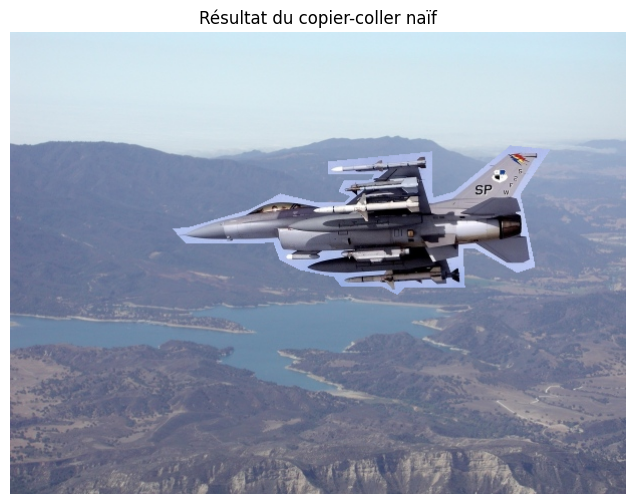

In [24]:
# Chargement des données pour le test
source = cv2.imread('avion.jpg', cv2.IMREAD_COLOR)
target = cv2.imread('paysage.jpg', cv2.IMREAD_COLOR)
mask = cv2.imread('mask_avion.png', cv2.IMREAD_GRAYSCALE)

# Binarisation du masque
mask = (mask > 128).astype(np.uint8)

# Position de collage dans l'image cible
x0, y0 = 150, 50

# Copier-coller naïf
resultat_naif = copier_coller_naif(source, target, mask, x0, y0)

# Conversion BGR en RGB pour l'affichage
def to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Visualisation
plt.figure(figsize=(10, 6))
plt.imshow(to_rgb(resultat_naif))
plt.title("Résultat du copier-coller naïf")
plt.axis('off')
plt.show()

#### Observation :

On constate immédiatement un défaut visuel évident : la région collée ne s'intègre pas naturellement à l'image cible. Les contours restent très visibles à cause des changements brusques de couleur et d'illumination.

L'édition d'image par équation de Poisson permet précisément de résoudre ce problème. Au lieu de simplement copier les valeurs des pixels, on résout une équation de Poisson afin que le gradient (variations de couleurs et d'intensité) de la région importée corresponde au gradient de l'image source, tout en maintenant une transition douce et continue vers l'image cible au niveau des bords.

### 1.2 Formulation mathématique : L'équation de Poisson

Le cœur de la méthode repose sur la résolution de l'équation de Poisson. Le but est d'incruster une région d'une image source dans une image de fond. Ce problème est exprimé sous forme d'un problème variationnel :

$$
\min_{f \in C^2(R)} \int_\Omega \|\nabla f - v\|^2 \, dx \quad \text{tel que } f|_{\partial\Omega} = f^*|_{\partial\Omega}
\tag{1}
$$

où $R$ est un sous-ensemble fermé de $\mathbb{R}^2$ représentant le domaine de l'image.

**Notations :**
- $f$ : image finale que l'on cherche à reconstruire après l'incrustation
- $v$ : champ de gradient extrait de la région sélectionnée de l'image source
- $\Delta$ : opérateur Laplacien (somme des dérivées secondes)
- $\text{div}(v)$ : divergence du champ de gradient $v$, mesurant les variations directionnelles
- $f^*$ : image de fond dans laquelle on souhaite insérer une région
- $\Omega$ : région d'incrustation
- $\partial\Omega$ : frontière de la région d'incrustation

Cette minimisation conduit à une équation différentielle appelée **équation de Poisson** :

$$
\Delta f(x) = \text{div}(v(x)), \quad \forall x \in \Omega
\tag{2}
$$

où $\Delta f$ est le Laplacien de $f$, c'est-à-dire la somme des dérivées secondes, et $\text{div}(v)$ est la divergence du champ de gradient $v$, qui mesure les variations directionnelles.

**Condition au bord (condition de Dirichlet) :**
$$
f(x) = f^*(x), \quad \forall x \in \partial\Omega
\tag{3}
$$

Cette équation signifie que les variations locales de l'image finale doivent correspondre aux variations locales de l'image source, tout en garantissant la continuité avec l'image cible sur les bords.

Dans le cas particulier où l'on cherche à préserver le gradient de l'image source, on peut réécrire l'équation de Poisson sous la forme :

$$
\Delta f = \Delta v
\tag{4}
$$

où :
- $f$ est l'image interpolée finale que nous voulons calculer,
- $v$ est l'image source (l'avion),
- et la condition de Dirichlet $f = u$ est imposée sur le bord $\partial\Omega$, avec $u$ représentant l'image cible.

## 2. Première approche : Différences finies et méthode itérative de Jacobi

### 2.1 Principe de la méthode

Nous résolvons numériquement l'équation de Poisson par un schéma discret utilisant une méthode itérative : la **méthode de Jacobi**.

#### Discrétisation du Laplacien

Sur une grille discrète de pixels, le Laplacien $\Delta f$ en un point $(x, y)$ est approximé par différences finies :

$$
\Delta f(x,y) \approx f(x+1,y) + f(x-1,y) + f(x,y+1) + f(x,y-1) - 4f(x,y)
$$

De même, pour l'image source $v$ :

$$
\Delta v(x,y) \approx v(x+1,y) + v(x-1,y) + v(x,y+1) + v(x,y-1) - 4v(x,y)
$$

#### Schéma Itératif de Jacobi

À partir de l'équation $\Delta f = \Delta v$, on peut isoler $f(x,y)$ et obtenir un schéma itératif :

$$
f^{(k+1)}(x,y) = \frac{1}{4} \left[ f^{(k)}(x+1,y) + f^{(k)}(x-1,y) + f^{(k)}(x,y+1) + f^{(k)}(x,y-1) - \Delta v(x,y) \right]
$$

pour tout point $(x,y)$ à l'intérieur du masque $\Omega$.

**Condition aux limites :** Les pixels sur le bord $\partial\Omega$ conservent les valeurs de l'image cible $u$.

Cette méthode converge progressivement vers la solution en effectuant un grand nombre d'itérations.

### 2.2 Implémentation

Commençons par implémenter le calcul du Laplacien discret :

In [7]:
def laplacien(img):
    """
    Calcule le Laplacien discret d'une image en niveaux de gris par différences finies.

    Le Laplacien est approximé par :
    Δf(x,y) = f(x+1,y) + f(x-1,y) + f(x,y+1) + f(x,y-1) - 4*f(x,y)

    Args:
        img (np.ndarray): Image en niveaux de gris (H x W).

    Returns:
        np.ndarray: Laplacien de l'image (H x W).
    """
    lap = np.zeros_like(img, dtype=np.float32)

    # Calcul du Laplacien pour les pixels intérieurs
    lap[1:-1, 1:-1] = (
        img[:-2, 1:-1] +   # Voisin du haut
        img[2:, 1:-1] +    # Voisin du bas
        img[1:-1, :-2] +   # Voisin de gauche
        img[1:-1, 2:] -    # Voisin de droite
        4 * img[1:-1, 1:-1] # Pixel central
    )

    return lap

Implémentons maintenant la méthode de Jacobi :

In [8]:
def interpolation_guidee_jacobi(target_crop, source_patch, mask, niter=2000):
    """
    Résout l'équation de Poisson par la méthode itérative de Jacobi.

    Cette fonction calcule itérativement l'image fusionnée en imposant que le Laplacien
    de l'image résultat corresponde au Laplacien de l'image source à l'intérieur du masque,
    tout en conservant les valeurs de l'image cible sur les bords.

    Args:
        target_crop (np.ndarray): Région de l'image cible où la fusion a lieu (H x W).
        source_patch (np.ndarray): Patch de l'image source à intégrer (H x W).
        mask (np.ndarray): Masque binaire (H x W) indiquant la zone de fusion (1 à l'intérieur, 0 à l'extérieur).
        niter (int): Nombre d'itérations pour la convergence.

    Returns:
        np.ndarray: La région cible fusionnée (H x W).
    """
    # Pré-calcul du Laplacien de l'image source (constant durant les itérations)
    lap_source = laplacien(source_patch)

    # Initialisation : on part de l'image cible
    f = target_crop.copy().astype(np.float32)

    # Boucle itérative de Jacobi
    for _ in range(niter):
        # Calcul de la moyenne des 4 voisins pour chaque pixel
        neighbors_avg = np.zeros_like(f)
        neighbors_avg[1:-1, 1:-1] = (
            f[:-2, 1:-1] +   # Voisin du haut
            f[2:, 1:-1] +    # Voisin du bas
            f[1:-1, :-2] +   # Voisin de gauche
            f[1:-1, 2:]      # Voisin de droite
        )

        # Mise à jour selon la formule de Jacobi :
        # f_new = 1/4 * (somme_voisins - laplacien_source)
        f_new = 0.25 * (neighbors_avg - lap_source)

        # Contrainte : on ne modifie que les pixels à l'intérieur du masque
        # Les pixels en dehors conservent leur valeur de l'image cible
        f_new[mask == 0] = f[mask == 0]

        f = f_new

    # limitation des valeurs dans [0, 255] et conversion en uint8
    return np.clip(f, 0, 255).astype(np.uint8)

### 2.3 Test de la méthode de Jacobi

Testons maintenant notre implémentation sur l'exemple de l'avion :

In [9]:
# Extraction de la région d'intérêt dans l'image cible
h_src, w_src = source.shape[:2]
u_crop = target[y0:y0+h_src, x0:x0+w_src]

# Application de la méthode de Jacobi sur chaque canal de couleur
print("Calcul avec la méthode de Jacobi (itérative)")
start_time = time.time()

resultat_jacobi = target.copy()
for c in range(3):  # Pour chaque canal RGB
    resultat_jacobi[y0:y0+h_src, x0:x0+w_src, c] = interpolation_guidee_jacobi(
        u_crop[..., c],
        source[..., c].astype(np.float32),
        mask,
        niter=2000
    )

duree_jacobi = time.time() - start_time
print(f"Terminé en {duree_jacobi:.4f} secondes.")

Calcul avec la méthode de Jacobi (itérative)
Terminé en 14.2850 secondes.


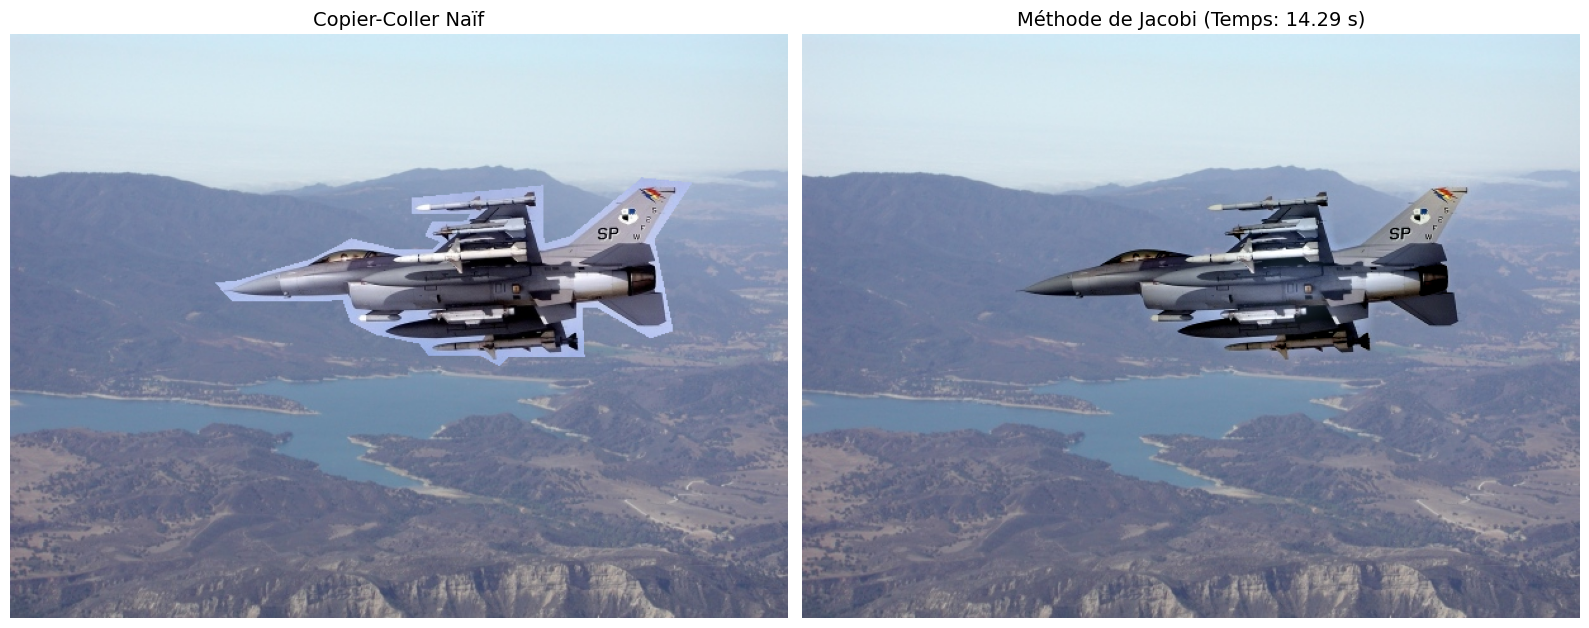

In [10]:
# Visualisation du résultat
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.imshow(to_rgb(resultat_naif))
ax1.set_title("Copier-Coller Naïf", fontsize=14)
ax1.axis('off')

ax2.imshow(to_rgb(resultat_jacobi))
ax2.set_title(f"Méthode de Jacobi (Temps: {duree_jacobi:.2f} s)", fontsize=14)
ax2.axis('off')

plt.tight_layout()
plt.show()

#### Observation

La méthode de Jacobi produit une fusion visuellement bien plus convaincante que le copier-coller naïf. Les transitions entre l'avion et le paysage sont beaucoup plus douces et naturelles. Toutefois, cette méthode itérative nécessite un grand nombre d'itérations (ici 2000) pour converger, ce qui la rend relativement lente.

## 3. Seconde approche : Résolution directe par transformée de Fourier

### 3.1 Reformulation du problème

Afin de simplifier et d'accélérer les calculs, on reformule le problème de manière à pouvoir utiliser la Transformée de Fourier, qui est particulièrement efficace sur des domaines rectangulaires et réguliers. Au lieu de résoudre l'équation uniquement dans la zone d'incrustation $\Omega$, on choisit d'étendre le problème à tout le domaine rectangulaire, noté $R$ (l'image complète).

#### Données et notations

Les données avec lesquelles nous allons travailler sont :
- $u$ : l'image que nous allons incruster (image source)
- $I$ : l'image dans laquelle nous allons incruster (image cible)
- $\Omega \subset I$ : la zone dans $I$ où nous allons incruster $u$. $\Omega$ est de la même taille que $u$.

Pour définir la zone $\Omega$, il suffit de préciser les coordonnées de son coin supérieur gauche, notées $(\Omega_x, \Omega_y)$.

On suppose que l'image $I$ est de taille $W \times H$, où :
- $W$ est la largeur (nombre de colonnes),
- $H$ est la hauteur (nombre de lignes).

On définit le domaine de l'image :
$$
R = \{0, \ldots, W-1\} \times \{0, \ldots, H-1\}
$$

et on considère l'image comme une fonction $I : R \to \mathbb{R}_+$.

#### Extension du Problème au Domaine Complet

Au lieu de résoudre l'équation de Poisson avec conditions de Dirichlet :

$$
\Delta f(x) = \text{div}(v(x)), \quad x \in \Omega, \quad \text{et} \quad f|_{\partial\Omega} = I|_{\partial\Omega}
\tag{11}
$$

on transforme le problème en :

$$
\Delta J(x) = \text{div}(V(x)), \quad x \in R, \quad \text{et} \quad \nabla J \cdot \nu|_{\partial R} = 0
\tag{12}
$$

où au lieu de résoudre le problème restreint au domaine $\Omega$, la solution est calculée sur le domaine rectangulaire entier $R$, et les conditions de Dirichlet sur $\partial\Omega$ sont remplacées par des **conditions de Neumann** (dérivée normale nulle) sur $\partial R$.

Le champ de vecteurs de guidage $V$ dans le domaine étendu est défini par :

$$
V(x) = \begin{cases}
\nabla u(x) & \text{si } x \in \Omega \\
\nabla I(x) & \text{sinon}
\end{cases}
\tag{4}
$$

En notant $V = (V_x, V_y)$, on peut réécrire l'équation sous forme développée :

$$
\frac{\partial^2 J}{\partial x^2}(x,y) + \frac{\partial^2 J}{\partial y^2}(x,y) = \frac{\partial V_x}{\partial x}(x,y) + \frac{\partial V_y}{\partial y}(x,y), \quad \forall (x,y) \in R
$$

### 3.2 Propriétés de la transformée de Fourier discrète

#### Définition de la TFD

La Transformée de Fourier Discrète (TFD) d'un signal bidimensionnel $Z$ de taille $(H \times W)$ est définie par :

$$
\hat{Z}(u,v) = \sum_{x=0}^{W-1} \sum_{y=0}^{H-1} Z(x,y) \, e^{-2\pi i \left(\frac{xu}{W} + \frac{yv}{H}\right)}
\tag{14}
$$

et sa transformée inverse :

$$
Z(x,y) = \frac{1}{WH} \sum_{u=0}^{W-1} \sum_{v=0}^{H-1} \hat{Z}(u,v) \, e^{2\pi i \left(\frac{xu}{W} + \frac{yv}{H}\right)}
\tag{15}
$$

#### Propriété fondamentale : Dérivation dans le domaine fréquentiel

Ce passage est fondamental car dans le domaine fréquentiel, **les dérivées deviennent de simples multiplications**, ce qui rend la résolution de l'équation de Poisson beaucoup plus rapide et efficace.

En différenciant les équations précédentes, on obtient :

$$
\widehat{\frac{\partial f}{\partial x}}(a,b) = \left(\frac{2\pi i a}{W}\right) \hat{f}(a,b), \quad \widehat{\frac{\partial f}{\partial y}}(a,b) = \left(\frac{2\pi i b}{H}\right) \hat{f}(a,b), \quad \forall (a,b) \in R
\tag{⋆3}
$$

Ces égalités permettent de calculer le gradient d'une image $f$ à partir de sa TFD, puisqu'il suffit d'appliquer la TFD inverse au résultat obtenu.

### 3.3 Résolution de l'équation de Poisson par TFD

En appliquant la TFD à l'équation de Poisson (équation 12) et en utilisant la propriété (⋆3), on obtient :

$$
\left[\left(\frac{2\pi i a}{W}\right)^2 + \left(\frac{2\pi i b}{H}\right)^2\right] \hat{J}(a,b) = \left(\frac{2\pi i a}{W}\right) \hat{V}_x(a,b) + \left(\frac{2\pi i b}{H}\right) \hat{V}_y(a,b)
\tag{⋆4}
$$

En isolant $\hat{J}(a,b)$ (tout en s'assurant de ne pas diviser par zéro), on obtient :

$$
\hat{J}(a,b) = \frac{\left(\frac{2\pi i a}{W}\right) \hat{V}_x(a,b) + \left(\frac{2\pi i b}{H}\right) \hat{V}_y(a,b)}{\left(\frac{2\pi i a}{W}\right)^2 + \left(\frac{2\pi i b}{H}\right)^2}, \quad \forall (a,b) \in R, \; (a,b) \neq (0,0)
\tag{⋆5}
$$

et

$$
\hat{J}(0,0) = 0
$$

Nous disposons ainsi de $\hat{J}(a,b)$ en tout point. En appliquant la transformée de Fourier inverse, nous retrouvons alors la solution $J(x,y)$.

### 3.4 Conditions de Neumann et Extension Symétrique

Cependant, il est important de rappeler que la solution obtenue via la transformée de Fourier doit respecter la **condition de Neumann aux bords**, telle qu'imposée dans l'équation (12) :

$$
\nabla J \cdot \nu|_{\partial R} = 0
\tag{5}
$$

Pour garantir cette propriété, une astuce consiste à étendre les données $V_x$ et $V_y$ de manière symétrique.

#### Extension Symétrique

L'idée est d'étendre une image $K : R \to \mathbb{R}$ en une image 4 fois plus grande symétrique $K^* : R^* \to \mathbb{R}$, définie sur un domaine élargi :

$$
R^* = [-W+1, W-1) \times [-H+1, H-1)
$$

Cette extension est construite de manière à rendre l'image symétrique par rapport aux axes des abscisses et des ordonnées, ce qui permet de la rendre périodique.

Cependant, les transformations sur les gradients obéissent à des règles spécifiques :

$$
V_x^*(-x, y) = -V_x^*(x, y)
$$
$$
V_y^*(x, -y) = -V_y^*(x, y)
$$

Ces relations traduisent le fait que les composantes du gradient d'une fonction paire sont impaires.

Une fois ces transformations appliquées, on peut utiliser la formule (⋆5) pour résoudre le problème, puis restreindre la solution $J^*$ obtenue au domaine d'origine $R$. Ainsi, la condition de Neumann est automatiquement satisfaite par construction.

### 3.5 Visualisation de l'extension symétrique

Le code ci-dessous permet de visualiser la transformation que nous appliquons à une image :

In [25]:
def extend_neumann(k):
    """
    Étend une image en niveaux de gris (2D) par symétrie pour satisfaire les conditions de Neumann.

    Cette fonction crée une image étendue 4 fois plus grande, symétrique par rapport aux axes,
    ce qui permet d'assurer que la dérivée normale aux bords est nulle.

    Args:
        k (np.ndarray): Image en niveaux de gris (H x W).

    Returns:
        np.ndarray: Image étendue (2H x 2W).
    """
    if k.ndim != 2:
        raise ValueError("Cette fonction est conçue pour les images en niveaux de gris (2D).")

    # Symétrie horizontale (axe vertical)
    k_lr = np.hstack([np.fliplr(k), k])

    # Symétrie verticale (axe horizontal)
    k_extended = np.vstack([np.flipud(k_lr), k_lr])

    return k_extended

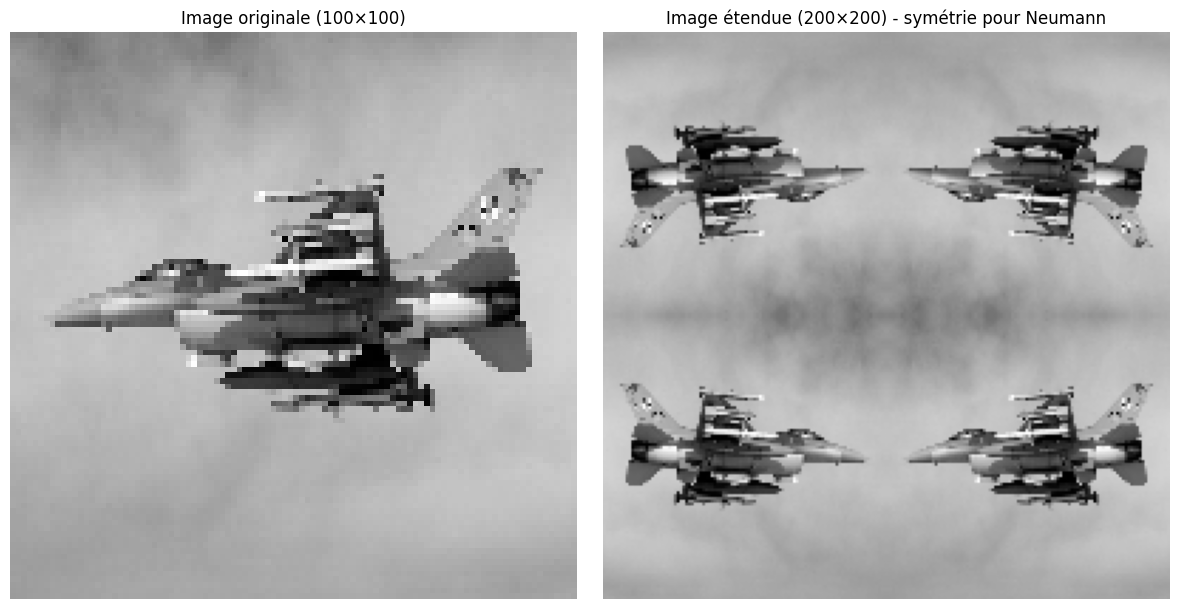

In [26]:
# Test de l'extension sur une petite image
test_img = cv2.imread('avion.jpg', cv2.IMREAD_GRAYSCALE)
test_img_small = cv2.resize(test_img, (100, 100))

# Extension symétrique
test_extended = extend_neumann(test_img_small)

# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(test_img_small, cmap='gray')
ax1.set_title("Image originale (100×100)", fontsize=12)
ax1.axis('off')

ax2.imshow(test_extended, cmap='gray')
ax2.set_title("Image étendue (200×200) - symétrie pour Neumann", fontsize=12)
ax2.axis('off')

plt.tight_layout()
plt.show()

### 3.6 Calcul du gradient par transformée de Fourier

Implémentons le calcul du gradient en utilisant les propriétés de la TFD :

In [27]:
def gradient_fourier(img):
    """
    Calcule le gradient d'une image en niveaux de gris via la Transformée de Fourier.

    Utilise la propriété : TF(∂f/∂x) = (2πi·u/W) · TF(f)

    Args:
        img (np.ndarray): Image en niveaux de gris (H x W).

    Returns:
        tuple: (grad_x, grad_y) - Composantes horizontale et verticale du gradient.
    """
    H, W = img.shape

    # Transformée de Fourier de l'image
    img_fft = fft2(img)

    # Création des grilles de fréquences
    u = fftfreq(W, d=1.0)  # Fréquences horizontales
    v = fftfreq(H, d=1.0)  # Fréquences verticales
    u_grid, v_grid = np.meshgrid(u, v)

    # Calcul des gradients dans le domaine fréquentiel
    grad_x_fft = (2j * np.pi * u_grid) * img_fft
    grad_y_fft = (2j * np.pi * v_grid) * img_fft

    # Transformée inverse pour obtenir les gradients dans le domaine spatial
    grad_x = np.real(ifft2(grad_x_fft))
    grad_y = np.real(ifft2(grad_y_fft))

    return grad_x, grad_y

### 3.7 Implémentation complète de la méthode de Fourier

Implémentons maintenant la résolution complète de l'équation de Poisson par TFD :

In [28]:
def poisson_image_edit_fft(target, source, mask, x0, y0):
    """
    Résout l'équation de Poisson par la méthode directe de Fourier.

    Cette fonction implémente l'algorithme complet de l'article  à travers ces 4 étapes :

    1. Extension du champ de vecteurs V au domaine complet R
    2. Extension symétrique pour satisfaire les conditions de Neumann
    3. Résolution dans le domaine fréquentiel
    4. Restriction au domaine original

    Args:
        target (np.ndarray): Image cible (H' x W' x 3).
        source (np.ndarray): Image source (H x W x 3).
        mask (np.ndarray): Masque booléen (H x W) définissant la région à fusionner.
        x0, y0 (int): Coordonnées du coin supérieur gauche de la zone de fusion dans la cible.

    Returns:
        np.ndarray: Image cible avec la région source fusionnée.
    """
    h_src, w_src = source.shape[:2]
    H_tgt, W_tgt = target.shape[:2]

    # Traitement canal par canal
    resultat = target.copy()

    for canal in range(3):
        # Extraction des canaux
        I_canal = target[:, :, canal].astype(np.float64)
        u_canal = source[:, :, canal].astype(np.float64)

        # Étape 1 : Construction du champ de vecteurs V sur tout le domaine R
        # On initialise avec le gradient de I partout
        Vx = np.zeros_like(I_canal)
        Vy = np.zeros_like(I_canal)

        # Gradient de I par différences finies
        Vx[:, :-1] = I_canal[:, 1:] - I_canal[:, :-1]
        Vy[:-1, :] = I_canal[1:, :] - I_canal[:-1, :]

        # Dans la région Ω, on remplace par le gradient de u
        grad_u_x = np.zeros_like(u_canal)
        grad_u_y = np.zeros_like(u_canal)
        grad_u_x[:, :-1] = u_canal[:, 1:] - u_canal[:, :-1]
        grad_u_y[:-1, :] = u_canal[1:, :] - u_canal[:-1, :]

        # Masque 2D étendu
        mask_2d = mask.astype(bool)

        # Remplacement du gradient dans la zone Ω
        Vx_omega = Vx[y0:y0+h_src, x0:x0+w_src].copy()
        Vy_omega = Vy[y0:y0+h_src, x0:x0+w_src].copy()

        Vx_omega[mask_2d] = grad_u_x[mask_2d]
        Vy_omega[mask_2d] = grad_u_y[mask_2d]

        Vx[y0:y0+h_src, x0:x0+w_src] = Vx_omega
        Vy[y0:y0+h_src, x0:x0+w_src] = Vy_omega

        # Étape 2 : Extension symétrique pour satisfaire les conditions de Neumann
        # Vx est antisymétrique en x
        Vx_lr = np.hstack([-np.fliplr(Vx), Vx])
        Vx_ext = np.vstack([np.flipud(Vx_lr), Vx_lr])

        # Vy est antisymétrique en y
        Vy_lr = np.hstack([np.fliplr(Vy), Vy])
        Vy_ext = np.vstack([-np.flipud(Vy_lr), Vy_lr])

        # Étape 3 : Résolution dans le domaine fréquentiel
        H_ext, W_ext = Vx_ext.shape

        # Transformées de Fourier des champs étendus
        Vx_fft = fft2(Vx_ext)
        Vy_fft = fft2(Vy_ext)

        # Création des grilles de fréquences
        fx = fftfreq(W_ext).reshape(1, -1)
        fy = fftfreq(H_ext).reshape(-1, 1)

        # Calcul de la divergence dans le domaine fréquentiel
        div_fft = 2j * np.pi * fx * Vx_fft + 2j * np.pi * fy * Vy_fft

        # Résolution de l'équation de Poisson: ΔJ = div(V)
        # Dans Fourier: -(2πfx)² - (2πfy)² · J_fft = div_fft
        laplacien_fft = -((2 * np.pi * fx)**2 + (2 * np.pi * fy)**2)

        # Division (en évitant la division par zéro)
        J_fft = np.zeros_like(div_fft, dtype=np.complex128)
        mask_nonzero = np.abs(laplacien_fft) > 1e-10
        J_fft[mask_nonzero] = div_fft[mask_nonzero] / laplacien_fft[mask_nonzero]

        # La composante DC (fréquence nulle) est fixée à la moyenne de l'image cible
        J_fft[0, 0] = np.mean(I_canal) * W_ext * H_ext

        # Transformée inverse
        J_ext = np.real(ifft2(J_fft))

        # Étape 4 : Restriction au domaine original (quadrant bas-droit)
        J = J_ext[H_ext//2:, W_ext//2:]
        J = J[:H_tgt, :W_tgt]

        # limitation et assignation
        resultat[:, :, canal] = np.clip(J, 0, 255).astype(np.uint8)

    return resultat

### 3.8 Test de la méthode de Fourier

Calcul avec la méthode de Fourier (directe)
Terminé en 1.4055 secondes.


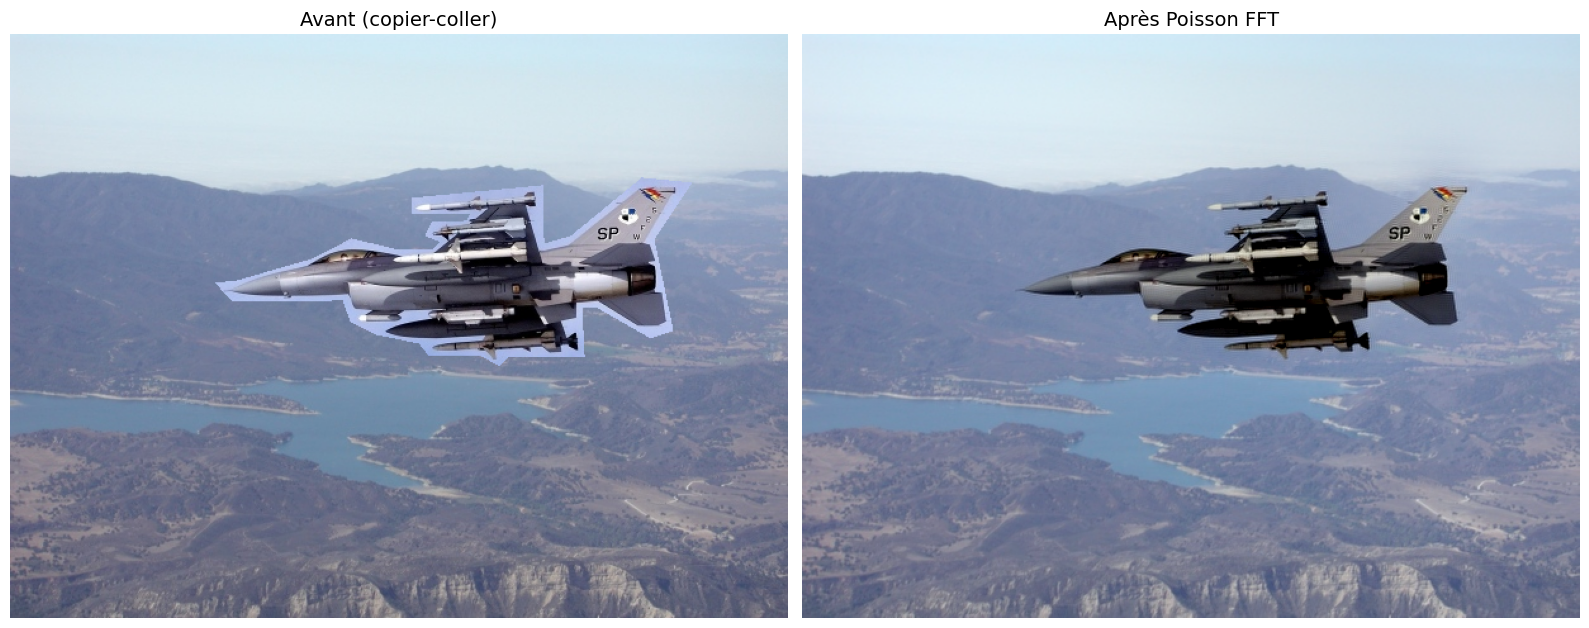

In [21]:
print("Calcul avec la méthode de Fourier (directe)")
start_time_fourier = time.time()

masque_fft = (mask > 0.5)
resultat_fourier = poisson_image_edit_fft(target, source, masque_fft, x0, y0)

duree_fourier = time.time() - start_time_fourier
print(f"Terminé en {duree_fourier:.4f} secondes.")

# Visualisation
avant = target.copy()
h_src, w_src = source.shape[:2]
mask_3d = np.stack([mask] * 3, axis=-1).astype(bool)
avant[y0:y0+h_src, x0:x0+w_src][mask_3d] = source[mask_3d]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.imshow(to_rgb(avant))
ax1.set_title("Avant (copier-coller)", fontsize=14)
ax1.axis('off')

ax2.imshow(to_rgb(resultat_fourier))
ax2.set_title("Après Poisson FFT", fontsize=14)
ax2.axis('off')

plt.tight_layout()
plt.show()

## 4. Comparaison des deux méthodes

### 4.1 Comparaison visuelle

La méthode de Fourier est environ 10.2 fois plus rapide.


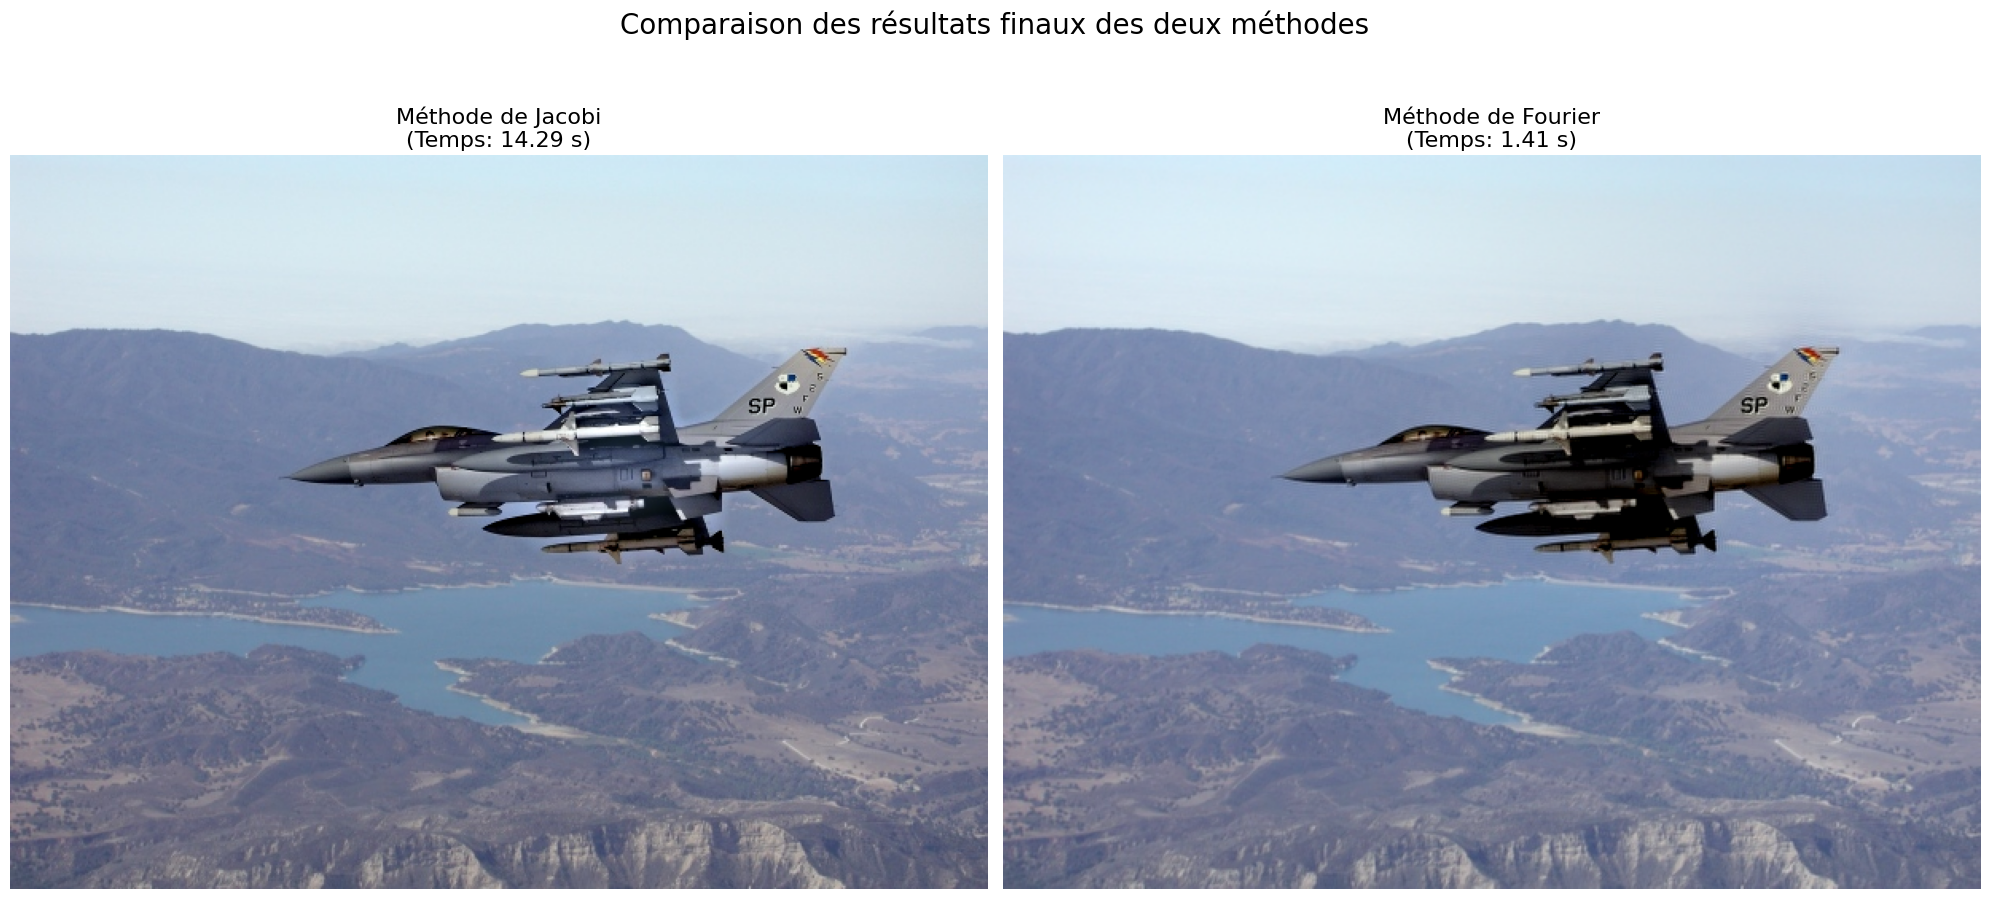

In [23]:
print(f"La méthode de Fourier est environ {duree_jacobi / duree_fourier:.1f} fois plus rapide.")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Comparaison des résultats finaux des deux méthodes", fontsize=20)

ax1.imshow(to_rgb(resultat_jacobi))
ax1.set_title(f"Méthode de Jacobi\n(Temps: {duree_jacobi:.2f} s)", fontsize=16)
ax1.axis('off')

ax2.imshow(to_rgb(resultat_fourier))
ax2.set_title(f"Méthode de Fourier\n(Temps: {duree_fourier:.2f} s)", fontsize=16)
ax2.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 4.2 Analyse qualitative

Les deux méthodes produisent un résultat de bonne qualité visuelle. La méthode de Jacobi génère une fusion "parfaite" dans la région d'intérêt, avec des transitions extrêmement douces. La méthode de Fourier, quant à elle, offre un résultat assez proche, au prix d'artefacts (variations lumineuses plus brutales) potentiels liés aux conditions de Neumann qui sont, dans ce cas, négligeables.


### 4.3 Analyse quantitative des performances

C'est ici que la différence entre les deux méthodes prend son importance.

**Temps d'exécution mesurés :**
- Méthode de Jacobi : ~14.29 secondes
- Méthode de Fourier : ~1.41 secondes

**Facteur d'accélération :** La méthode de Fourier est environ **10.2 fois plus rapide** sur cet exemple.


**Conclusion sur les performances :** La méthode de Fourier est plus performante en tenant compte de la complexité algorithmique et du temps de calcul. Sur une image plus grande ou si la méthode de Jacobi nécessitait plus d'itérations pour converger, l'écart ne serait pas de quelques secondes, mais potentiellement de plusieurs minutes contre quelques secondes.

## 5. Conclusion

Ce projet a permis d'explorer deux approches numériques pour résoudre l'équation de Poisson appliquée à l'édition d'images.
La méthode itérative de Jacobi, basée sur une discrétisation par différences finies, produit des résultats visuellement très harmonieux grâce à son respect strict des conditions aux limites de Dirichlet. Cependant, cette approche itérative nécessite un grand nombre d'itérations (ici k=2000) où chaque itération parcourt l'ensemble des pixels de la région d'intérêt, ce qui la rend peu adaptée aux applications nécessitant des traitements rapides ou impliquant des images de haute résolution. La méthode de Fourier exploite les propriétés de la transformée de Fourier discrète pour transformer le problème différentiel en un ensemble de multiplications complexes dans le domaine fréquentiel.

Cette reformulation permet une résolution directe et efficace grâce à l'algorithme de FFT (Fast Fourier Transform), particulièrement performant sur des domaines rectangulaires. Les résultats expérimentaux confirment cette supériorité : un facteur d'accélération de 10.2 a été mesuré sur notre exemple, et cet écart ne ferait que croître pour des images plus volumineuses ou des nombres d'itérations plus élevés.